In [1]:
import sys
sys.path.append('../..')

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from dataset.cotter_dataset import CotterData
import torch.distributions as dist

In [96]:
class HybridGR4J(nn.Module):
    
    def __init__(self, s_init):
        
        super(HybridGR4J, self).__init__()

        # GR4J param
        self.s_init = torch.tensor(s_init)
        self.x1 = torch.tensor(579.6377, requires_grad=False) # nn.Parameter(dist.uniform.Uniform(100, 1200).sample())
        # self.register_parameter(name='x1', param=self.x1)

        # NN
        self.h1 = nn.Linear(8, 64)
        self.h2 = nn.Linear(64, 32)
        self.h3 = nn.Linear(32, 16)
        self.o = nn.Linear(16, 1)

        self.g = F.relu


    def forward(self, x):

        P = x[:, 0]
        E = x[:, 1]
        
        # Number of simulation timesteps
        num_timesteps = len(P)
        
        # Unpack the model parameters
        x1 = self.x1

        # Production Storage
        p_n = torch.relu(P - E)
        e_n = torch.relu(E - P)

        p_s_list = []
        e_s_list = []
        perc_list = []
        s_store_list = []

        s_store = self.s_init * x1

        for t in range(num_timesteps):
            # calculate fraction of netto precipitation that fills
            #  production store (eq. 3)
            p_s = x1 * (1 - (s_store/ x1)**2) * torch.tanh(p_n[t]/x1) / (1 + (s_store / x1) * torch.tanh(p_n[t] / x1))

            # from the production store (eq. 4)
            e_s = s_store * (2 - s_store/x1) * torch.tanh(e_n[t]/x1) / (1 + (1 - s_store/x1) * torch.tanh(e_n[t] / x1))

            s_store = s_store + p_s - e_s

            # calculate percolation from actual storage level
            perc = s_store * (1 - (1 + (4/9 * s_store / x1)**4)**(-0.25))
            
            # final update of the production store for this timestep
            s_store = s_store - perc

            # Append updated values
            p_s_list.append(p_s)
            e_s_list.append(e_s)
            perc_list.append(perc)
            s_store_list.append(s_store)
            

        # Expand dim
        p_n = p_n[:, None]
        e_n = e_n[:, None]
        p_s = torch.stack(p_s_list)[:, None] 
        perc = torch.stack(perc_list)[:, None]
        
        # Concatenate
        inp = torch.concat([x, p_n, e_n, p_s, perc], dim=1)

        # ANN
        out = self.g(self.h1(inp.float()))
        out = self.g(self.h2(out))
        out = self.g(self.h3(out))
        out = self.o(out)

        return out


In [97]:
def list_parameters(model):
    for n, p in model.named_parameters():
        print(f"Parameter name: {n}, contains: {p.data}, requires_grad: {p.requires_grad}")

In [98]:
train_dates = (dt.datetime(1991, 1, 1), dt.datetime(2010, 12, 31))
val_dates = (dt.datetime(2011, 1, 1), dt.datetime(2020, 12, 31))

ds = CotterData('../../dataset/dataconfig.yml', train_dates=train_dates, val_dates=val_dates, keep_z=False, create_seq=True)

ds = CotterData(
    config_file='../../dataset/dataconfig.yml', 
    train_dates=train_dates, val_dates=val_dates,
    scale=True,
    create_seq=False,
    keep_z=False,
    X_col=['daily_rain', 'et_tall_crop', 'min_temp', 'max_temp']
)

In [99]:
trainset = ds.trainset
valset = ds.valset

In [100]:
X_train, y_train = trainset.tensors
X_val, y_val = valset.tensors

In [101]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [105]:
hybrid_gr4j = HybridGR4J(s_init=100)

opt = torch.optim.Adam(hybrid_gr4j.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
n_epochs = 250

hybrid_gr4j.train()

HybridGR4J(
  (h1): Linear(in_features=8, out_features=32, bias=True)
  (h2): Linear(in_features=32, out_features=8, bias=True)
  (h3): Linear(in_features=8, out_features=16, bias=True)
  (o): Linear(in_features=16, out_features=1, bias=True)
)

In [106]:
early_stopper = EarlyStopper(patience=10, min_delta=0.01)

In [107]:
pbar = tqdm(range(n_epochs))
hybrid_gr4j.train()

for epoch in pbar:

    opt.zero_grad()

    y_hat = hybrid_gr4j(X_train)

    loss = loss_fn(y_train, y_hat)

    loss.backward()

    opt.step()

    hybrid_gr4j.eval()
    y_val_hat = hybrid_gr4j(X_val)
    val_loss = loss_fn(y_val, y_val_hat)
    
    pbar.set_description(f"Epoch {epoch+1} loss: {loss.detach().numpy():.4f} val_loss: {val_loss.detach().numpy():.4f}")


    if early_stopper.early_stop(val_loss):
        break

    

Epoch 250 loss: 0.5017 val_loss: 0.9751: 100%|██████████| 250/250 [05:24<00:00,  1.30s/it] 


In [108]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def normalize(x):
    return 1/(2 - x)

def evaluate(model, X, y):

    y_hat = model(X)

    flow = y.detach().numpy()
    flow_pred = y_hat.detach().numpy()

    nse_score = nse(flow, flow_pred)
    nnse_score = normalize(nse_score)

    print(f"NSE: {nse_score:.3f}")
    print(f"Normalized NSE: {nnse_score:.3f}")


    # Post processing
    flow_pred = ds.y_scaler.inverse_transform(flow_pred)
    flow = ds.y_scaler.inverse_transform(flow)


    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(flow, color='black', label='obs', alpha=1.0)
    ax.plot(flow_pred, color='red', label='pred', alpha=0.7)
    # ax.plot(dates, prcp.detach().numpy(), 'g--', label='precip', alpha=0.45)
    # ax.plot(dates, et.detach().numpy(), 'y--', label='etp', alpha=0.45)

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

    return flow_pred, flow

NSE: 0.366
Normalized NSE: 0.612


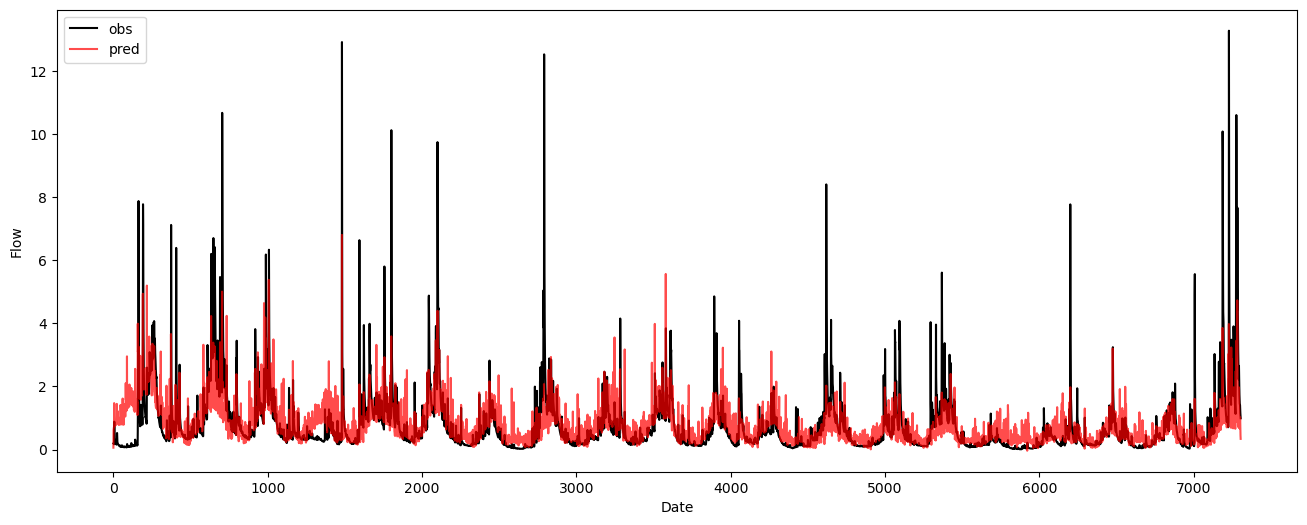

In [109]:
_, _ = evaluate(hybrid_gr4j, X_train, y_train)

NSE: 0.168
Normalized NSE: 0.546


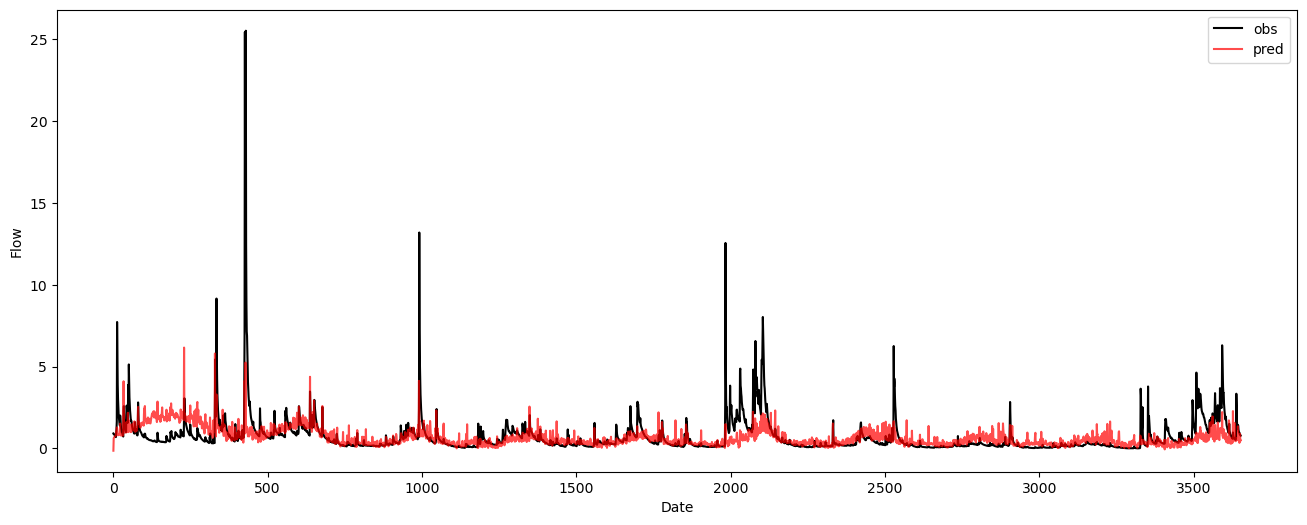

In [110]:
_, _ = evaluate(hybrid_gr4j, X_val, y_val)